In [1]:
import numpy as np
import matplotlib.pyplot as plt

% matplotlib inline

In [2]:
Xy_numu = np.load("Xy_numu_reco.npz")
Xy_nue = np.load("Xy_nue_reco.npz")

In [3]:
X_numu = Xy_numu["x"]
y_numu = Xy_numu["y"]

In [4]:
X_nue = Xy_nue["x"]
y_nue = Xy_nue["y"]

np.save("X_numu.npy",X_numu)
np.save("Y_numu.npy",Y_numu)
np.save("X_nue.npy",X_nue)
np.save("Y_nue.npy",Y_nue)

In [5]:
print('X_numu: ', X_numu.shape, 'X_nue: ', X_nue.shape, 'y_numu: ', y_numu.shape, 'y_nue: ', y_nue.shape)

('X_numu: ', (1569, 36, 16, 15, 18), 'X_nue: ', (1183, 36, 16, 15, 18), 'y_numu: ', (1569,), 'y_nue: ', (1183,))


In [6]:
X = np.vstack((X_numu, X_nue))

In [7]:
y = np.hstack((y_numu, y_nue))

In [8]:
import keras

Using TensorFlow backend.


In [9]:
from tensorflow.python.client import device_lib

def get_available_gpus():
    local_device_protos = device_lib.list_local_devices()
    return [x.name for x in local_device_protos if x.device_type == 'GPU']

In [10]:
get_available_gpus()

[u'/gpu:0']

In [11]:
keras.backend.image_data_format()

'channels_first'

In [12]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold

In [13]:
from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation, Flatten
from keras.optimizers import SGD
from keras.layers.convolutional import Conv3D, MaxPooling3D, ZeroPadding3D
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
from keras.losses import categorical_crossentropy

In [14]:
from history_plot import history_plot

In [15]:
print("X size: %d, y size: %d" %(X.shape[0], y.shape[0]) )

X size: 2752, y size: 2752


In [16]:
indices = np.arange(X.shape[0])
X_train, X_test, y_train, y_test, indx_train, indx_test = train_test_split(X, y, indices, test_size=0.20, 
                                                                           random_state=42, stratify=y)

In [17]:
print(X_train.shape, y_train.shape, indx_train.shape)
print(X_test.shape, y_test.shape, indx_test.shape)

((2201, 36, 16, 15, 18), (2201,), (2201,))
((551, 36, 16, 15, 18), (551,), (551,))


In [18]:
# Check that Stratification worked
print(y[y==0].shape, y_train[y_train==0].shape, y_test[y_test==0].shape)
print(y[y==1].shape, y_train[y_train==1].shape, y_test[y_test==1].shape)

((1183,), (946,), (237,))
((1569,), (1255,), (314,))


In [19]:
img_channel = X_train.shape[1]
conv_dim_1 = X_train.shape[2]
conv_dim_2 = X_train.shape[3]
conv_dim_3 = X_train.shape[4]
inputshape = (img_channel, conv_dim_1, conv_dim_2, conv_dim_3)
print(inputshape)

(36, 16, 15, 18)


##### Setup Model Callbacks

In [20]:
early_stop = EarlyStopping(monitor='val_loss', patience=5, verbose=1)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1,
                              patience=2, min_lr=1e-4, verbose=1)

early_stop_noval = EarlyStopping(monitor='loss', patience=5, verbose=1)
reduce_lr_noval = ReduceLROnPlateau(monitor='loss', factor=0.1,
                              patience=2, min_lr=1e-4, verbose=1)

#### Create Deep Network Model

In [21]:
def cnn_model(num_classes, optimizer):
    model = Sequential()
    model.add(Conv3D(128, kernel_size=(3, 3, 3), activation='relu', input_shape=inputshape))
    model.add(Conv3D(64, (3, 3, 3), activation='relu'))
    model.add(MaxPooling3D(pool_size=(2, 2, 2)))
    model.add(Dropout(0.1))
    model.add(Conv3D(32, (3, 3, 3), activation='relu'))
    model.add(Dropout(0.25))
    model.add(Conv3D(32, (3, 3, 3), activation='relu'))
    model.add(Flatten())
    model.add(Dense(256,activation='relu'))
    model.add(Dense(num_classes, activation='softmax'))

    model.compile(loss=categorical_crossentropy, optimizer=optimizer, metrics=['accuracy'])
    return model

In [22]:
from keras.backend import clear_session

def cross_validation_score(K, N, X_train, y_train, f_model, f_args, fit_args):
    """"""
    iteration_tr_score = list()
    iteration_val_score = list()
    histories_cnn = list()
    
    def iteration_metrics(scores):
        mean_score = np.mean(scores)
        min_score = np.min(scores)
        max_score = np.max(scores)
        return mean_score, min_score, max_score
    
    for iteration in range(N):
        tr_accuracy_scores = list()
        val_accuracy_scores=list()
        
        skf = StratifiedKFold(n_splits=K, random_state=iteration)
        
        for i, (train_index, validation_index) in enumerate(skf.split(X_train, y_train)):
            print("[Iteration %d/%d] Test nr.: %d/%d" % (iteration+1, N, i+1, K))
            
            Xtrain, Xvalidation = X_train[train_index], X_train[validation_index]
            ytrain, yvalidation = y_train[train_index], y_train[validation_index]

            model = f_model(**f_args)
            
            if iteration == 0 and i == 0:
                model.summary()
            
            Ytrain = to_categorical(ytrain)
            Yvalidation = to_categorical(yvalidation)
            history = model.fit(Xtrain, Ytrain, validation_data = (Xvalidation, Yvalidation), 
                                shuffle=False, **fit_args) 
                        
            histories_cnn.append(history)
            training_acc = history.history['acc'][-1]
            validation_acc = history.history['val_acc'][-1]
            
            print("\nTraining acc: %f, Validation acc: %f\n" %(training_acc,validation_acc))
            tr_accuracy_scores.append(training_acc)
            val_accuracy_scores.append(validation_acc)
            
        iteration_tr_score.append(iteration_metrics(tr_accuracy_scores))
        iteration_val_score.append(iteration_metrics(val_accuracy_scores))
        
    clear_session()
        
    print("Training metrics: ")
    print("ITER \t MEAN \t MIN \t MAX")
    for it, metric in enumerate(iteration_tr_score):
        print("{0:d} \t {1:.3f} \t {2:.3f} \t {3:.3f}".format(it+1, *metric))
    
    print("Validation metrics: ")
    print("ITER \t MEAN \t MIN \t MAX")
    for it, metric in enumerate(iteration_val_score):
        print("{0:d} \t {1:.3f} \t {2:.3f} \t {3:.3f}".format(it+1, *metric))

    return histories_cnn

In [23]:
n_splits = 3
n_iterations = 2
fargs = {'num_classes': 2, 'optimizer': keras.optimizers.Adadelta()}
fitargs = {'batch_size': 64, 'epochs': 30, 'callbacks': [early_stop], 'verbose': 1}
history_info = cross_validation_score(K=n_splits, N=n_iterations, X_train=X_train, y_train=y_train, 
                                      f_model=cnn_model, f_args=fargs, fit_args=fitargs)

[Iteration 1/2] Test nr.: 1/3
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_1 (Conv3D)            (None, 128, 14, 13, 16)   124544    
_________________________________________________________________
conv3d_2 (Conv3D)            (None, 64, 12, 11, 14)    221248    
_________________________________________________________________
max_pooling3d_1 (MaxPooling3 (None, 64, 6, 5, 7)       0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 64, 6, 5, 7)       0         
_________________________________________________________________
conv3d_3 (Conv3D)            (None, 32, 4, 3, 5)       55328     
_________________________________________________________________
dropout_2 (Dropout)          (None, 32, 4, 3, 5)       0         
_________________________________________________________________
conv3d_4 (Conv3D)            (None, 32, 2, 1, 

1468/1468 [==============================] - 4s - loss: 0.6499 - acc: 0.6151 - val_loss: 1.0081 - val_acc: 0.5703
Epoch 4/30
1468/1468 [==============================] - 3s - loss: 0.6332 - acc: 0.6390 - val_loss: 0.8088 - val_acc: 0.5757
Epoch 5/30
1468/1468 [==============================] - 4s - loss: 0.5988 - acc: 0.6567 - val_loss: 0.7324 - val_acc: 0.5975
Epoch 6/30
1468/1468 [==============================] - 3s - loss: 0.5790 - acc: 0.7071 - val_loss: 0.7217 - val_acc: 0.6262
Epoch 7/30
1468/1468 [==============================] - 4s - loss: 0.5158 - acc: 0.7452 - val_loss: 0.6020 - val_acc: 0.6398
Epoch 8/30
1468/1468 [==============================] - 4s - loss: 0.4463 - acc: 0.7834 - val_loss: 0.8780 - val_acc: 0.6071
Epoch 9/30
1468/1468 [==============================] - 4s - loss: 0.4289 - acc: 0.8052 - val_loss: 0.6036 - val_acc: 0.6849
Epoch 10/30
1468/1468 [==============================] - 4s - loss: 0.3618 - acc: 0.8345 - val_loss: 0.7868 - val_acc: 0.6576
Epoch 11/3

In [24]:
import history_plot
reload(history_plot)
len(history_info)

6

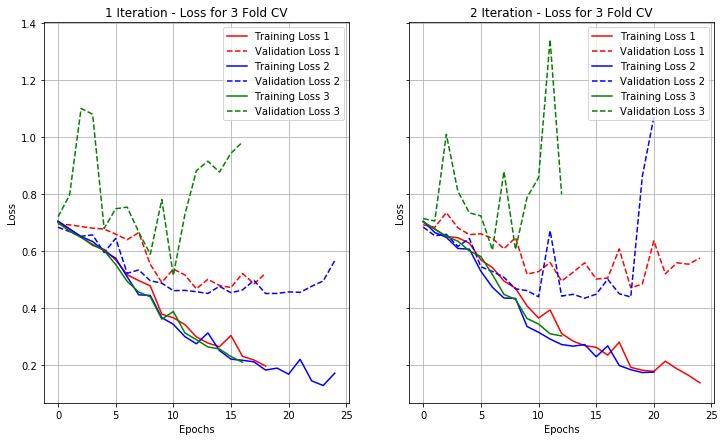

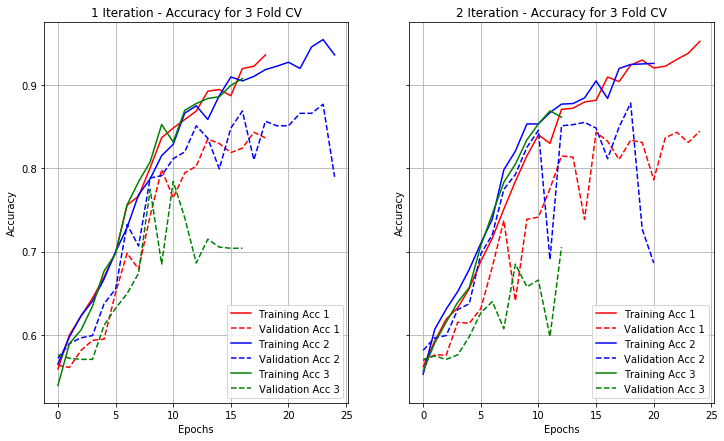

In [25]:
 %matplotlib inline
history_plot.history_plot_cv(history_info,"", "show", K=n_splits, N=n_iterations)

In [26]:
Ytrain = to_categorical(y_train)
batch = 64
epochs = 30
print("Train model on the whole train dataset - no validation")
model=cnn_model(num_classes= 2, optimizer=keras.optimizers.Adadelta())
repl_history = model.fit(X_train, Ytrain, batch_size=batch, epochs=epochs, callbacks=[early_stop_noval])  # replicate conf.


Train model on the whole train dataset - no validation
Epoch 1/30
2201/2201 [==============================] - 4s - loss: 0.6974 - acc: 0.5693     
Epoch 2/30
2201/2201 [==============================] - 4s - loss: 0.6684 - acc: 0.5938     
Epoch 3/30
2201/2201 [==============================] - 4s - loss: 0.6274 - acc: 0.6524     
Epoch 4/30
2201/2201 [==============================] - 4s - loss: 0.5749 - acc: 0.7233     
Epoch 5/30
2201/2201 [==============================] - 4s - loss: 0.4721 - acc: 0.7846     
Epoch 6/30
2201/2201 [==============================] - 4s - loss: 0.4169 - acc: 0.8169     
Epoch 7/30
2201/2201 [==============================] - 4s - loss: 0.3691 - acc: 0.8528     
Epoch 8/30
2201/2201 [==============================] - 4s - loss: 0.3413 - acc: 0.8505     
Epoch 9/30
2201/2201 [==============================] - 4s - loss: 0.3179 - acc: 0.8637     
Epoch 10/30
2201/2201 [==============================] - 4s - loss: 0.3016 - acc: 0.8655     
Epoch 11/30
22

In [27]:
print("Use model to make prediction on test data")
predictions = model.predict(X_test)
cls_predictions = np.argmax(predictions, axis=1)

from sklearn.metrics import accuracy_score
score = accuracy_score(y_test, cls_predictions)
print("Accuracy score: ", score)

Use model to make prediction on test data
('Accuracy score: ', 0.8784029038112523)


In [28]:
from sklearn.metrics import confusion_matrix
conf_matrix = confusion_matrix(y_test, cls_predictions)

print("Confusion matrix: ")
print(conf_matrix)

print("indices of the wrongly classified events: ")
wrong_class_evt = indx_test[np.where(cls_predictions!=y_test)]
print(wrong_class_evt)
print("{} misclassified events out of {} --> {}%".format(wrong_class_evt.size,y_test.size,
                                                            np.true_divide((y_test.size-wrong_class_evt.size),y_test.size)))


Confusion matrix: 
[[221  16]
 [ 51 263]]
indices of the wrongly classified events: 
[ 395 1181 1108  182 1249  793  127 2425   54 2529 1246  130 1470 2178  593
 2439 2497 1577  893 1450 1109   58  735 1691  924  997  820  292 2388   46
 2077  713  101  145 1022  592  476 1831 1252 2521  814   72 1838 2498  904
 1184  938 1143 1101 1379  985 2613  215 1311   26 1374  153  726  645  146
 1664 1378 2544  545  934  274  431]
67 misclassified events out of 551 --> 0.878402903811%


In [29]:
wrong_class_evt_numu = wrong_class_evt[wrong_class_evt<X_numu.shape[0]]

In [30]:
wrong_class_evt_nue = wrong_class_evt[wrong_class_evt>X_numu.shape[0]] - X_numu.shape[0]

In [31]:
print(wrong_class_evt_numu, wrong_class_evt_nue)

(array([ 395, 1181, 1108,  182, 1249,  793,  127,   54, 1246,  130, 1470,
        593,  893, 1450, 1109,   58,  735,  924,  997,  820,  292,   46,
        713,  101,  145, 1022,  592,  476, 1252,  814,   72,  904, 1184,
        938, 1143, 1101, 1379,  985,  215, 1311,   26, 1374,  153,  726,
        645,  146, 1378,  545,  934,  274,  431]), array([ 856,  960,  609,  870,  928,    8,  122,  819,  508,  262,  952,
        269,  929, 1044,   95,  975]))


In [32]:
numufile = "utilities/km3_v4_numucc_1_B.evt.aa.root"
nuefile = "utilities/km3_v4_nuecc_1.evt.JTE.aa.root"

In [44]:
import ROOT
import root_numpy as rnp

In [46]:
E_numu = rnp.root2array(numufile, treename='E', branches='Evt.mc_trks.E')
type_numu = rnp.root2array(numufile, treename='E', branches = 'Evt.mc_trks.type')
E_nue = rnp.root2array(nuefile, treename='E', branches='Evt.mc_trks.E')
type_nue = rnp.root2array(nuefile, treename='E', branches = 'Evt.mc_trks.type')


E_numu_ = np.asarray([E_numu[evt][type_numu[evt]==5][0]for evt in range(E_numu.shape[0])])

E_nue_ = np.asarray([E_nue[evt][type_nue[evt]==3][0]for evt in range(E_nue.shape[0])])


In [47]:
E_numu_[wrong_class_evt_numu]
E_nue_[wrong_class_evt_nue]

array([  1.14757000e+05,   9.78496000e+02,   4.98240000e+02,
         4.93355000e+03,   1.57173000e+03,   7.32269000e+02,
         1.32913000e+03,   1.12715000e+03,   2.95633000e+04,
         1.35398000e+03,   1.39607000e+05,   1.47301000e+04,
         2.74210000e+03,   8.85677000e+03,   9.91460000e+01,
         3.32351000e+02,   1.91114000e+04])

In [48]:
nbins = 12
log_MC_en = np.log10(E_numu_) 
log_minE = np.min(log_MC_en) #np.log10(np.int(np.min(montecarlo_energies)))
log_maxE = np.max(log_MC_en) #np.log10(np.int(np.max(montecarlo_energies)))
        
log_evts = np.log10(wrong_class_evt_numu) 
    #binned log energies calculation with np.histogram
MC_events_per_bin, _ = np.histogram(log_MC_en, bins=nbins, range=(log_minE, log_maxE))
wrong_evts_per_bin, energy_bins = np.histogram(log_evts, bins=nbins, range=(log_minE,log_maxE))

In [49]:
fraction = np.true_divide(wrong_evts_per_bin, MC_events_per_bin)

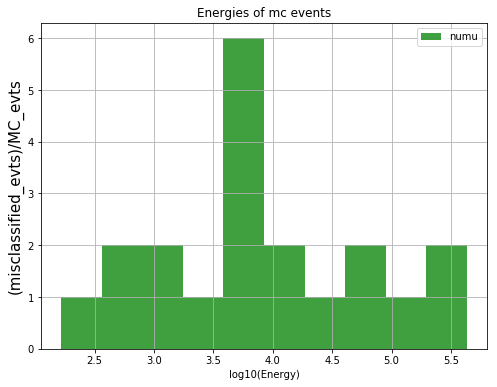

In [50]:
% matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

plt.figure(figsize=(8,6))
plt.hist(np.log10(E_numu_[wrong_class_evt_numu]), normed=False, facecolor='g', alpha=0.75, label="numu")
#plt.hist(np.log10(E_nue_[wrong_class_evt_nue]), normed=False,  facecolor="blue", alpha=0.5, label="nue")
#plt.hist(np.log10(E_numu_), normed=False, facecolor='b', alpha=0.5, label="numu")
#plt.plot(energy_bins[1:], fraction)

#plt.hist(np.log10(E_numu_), bins=energy_bins)
plt.xlabel("log10(Energy)")
plt.ylabel("(misclassified_evts)/MC_evts", size=15)
plt.xscale("linear")
plt.title('Energies of mc events')
plt.legend(loc="upper right")
plt.grid(True)
plt.show()

In [33]:
i=[]
j=[]
k=[]
for ii,x in enumerate(range(-300,1100,90)):
    for jj,y in enumerate(np.arange(-550,550, 45*np.sqrt(3))):
        for kk,z in enumerate(range(98,712,36)):
            i.append(ii)
            j.append(jj)
            k.append(kk)
        x-= 45
l_i = np.asarray(i)
l_j = np.asarray(j)
l_k = np.asarray(k)


arr = []
for i,j,k in zip(l_i,l_j,l_k):
    arr.append((i,j,k))
lol = np.asarray(arr)



In [34]:
def plot_x_evt(evt):
    ggg = np.sum(X_numu[evt], axis=0)
    hhh = np.nonzero(ggg)
    return ax.scatter(hhh[0],hhh[1],hhh[2], alpha=0.9)


In [35]:
wrong_class_evt_numu

array([ 395, 1181, 1108,  182, 1249,  793,  127,   54, 1246,  130, 1470,
        593,  893, 1450, 1109,   58,  735,  924,  997,  820,  292,   46,
        713,  101,  145, 1022,  592,  476, 1252,  814,   72,  904, 1184,
        938, 1143, 1101, 1379,  985,  215, 1311,   26, 1374,  153,  726,
        645,  146, 1378,  545,  934,  274,  431])

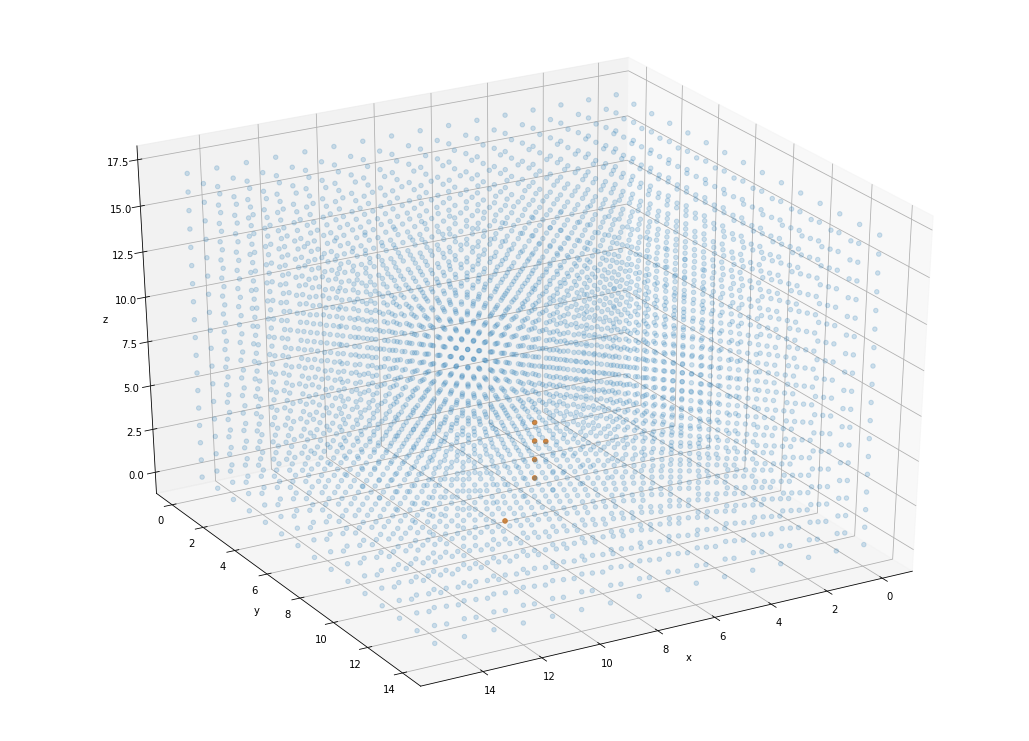

In [44]:

from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure(figsize=(14,10))
ax = Axes3D(fig)

ax.scatter(lol[:,0], lol[:,1], lol[:,2], alpha=0.2)
#for evt in wrong_class_evt_numu:
#    plot_x_evt(evt)
plot_x_evt(54)
ax.grid()
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')
ax.view_init(30, 60)
plt.show()


In [84]:
Xy_numu2 = np.load("Xy_numu2_sel5.npz")
Xy_nue2 = np.load("Xy_nue2_sel5.npz")


X_numu2 = Xy_numu2["x"]
y_numu2 = Xy_numu2["y"]


X_nue2 = Xy_nue2["x"]
y_nue2 = Xy_nue2["y"]



In [85]:
print('X_numu2: ', X_numu2.shape, 'X_nue2: ', X_nue2.shape, 'y_num2u: ', y_numu2.shape, 'y_nue2: ', y_nue2.shape)

('X_numu2: ', (1533, 75, 16, 15, 18), 'X_nue2: ', (1104, 75, 16, 15, 18), 'y_num2u: ', (1533,), 'y_nue2: ', (1104,))


In [86]:
X2 = np.vstack((X_numu2, X_nue2))
y2 = np.hstack((y_numu2, y_nue2))

In [60]:
np.random.shuffle?

In [87]:
indices = range(y2.size)

In [89]:
np.random.shuffle(indices)

In [90]:
sh_X2 = X2[indices]

In [91]:
sh_y2 = y2[indices]

In [92]:
sh_y2[:10]

array([1, 1, 1, 0, 0, 0, 1, 1, 1, 0], dtype=uint8)

In [94]:
print("Use model to make prediction on new data")
predictions = model.predict(sh_X2)
cls_predictions = np.argmax(predictions, axis=1)

from sklearn.metrics import accuracy_score
score = accuracy_score(sh_y2, cls_predictions)
print("Accuracy score: ", score)

Use model to make prediction on new data
('Accuracy score: ', 0.8555176336746303)


In [102]:
from sklearn.metrics import confusion_matrix
conf_matrix = confusion_matrix(sh_y2, cls_predictions)

print("Confusion matrix: ")
print(conf_matrix)

print("indices of the wrongly classified events: ")
wrong_class_evt = np.where(cls_predictions!=sh_y2)[0]
print(wrong_class_evt)
print("{} misclassified events out of {} --> {}%".format(wrong_class_evt.size,sh_y2.size,
                                                            np.true_divide((sh_y2.size-wrong_class_evt.size),sh_y2.size)))


Confusion matrix: 
[[1042   62]
 [ 319 1214]]
indices of the wrongly classified events: 
[   0    1    2    6   16   18   46   47   49   66   75   95  103  106  107
  110  114  122  124  128  129  136  153  164  176  198  208  211  220  222
  226  227  228  240  245  250  260  274  277  279  280  283  291  299  300
  308  312  333  342  347  350  352  353  354  359  368  442  444  455  459
  461  467  469  480  492  497  499  504  506  509  512  519  523  524  536
  542  546  548  560  567  569  577  582  585  588  589  590  595  596  598
  600  602  603  630  631  632  635  638  650  651  673  685  687  688  689
  696  720  724  730  733  734  737  756  763  782  791  792  793  797  798
  799  807  822  825  827  831  832  844  846  849  862  865  869  874  883
  904  906  910  917  925  926  936  948  952  957  962  969  970  971  978
  992  993 1005 1010 1014 1015 1018 1019 1027 1028 1029 1036 1050 1054 1063
 1067 1090 1095 1115 1136 1150 1160 1162 1176 1182 1191 1192 1195 1202 1204

In [103]:
wrong_class_evt_numu2 = wrong_class_evt[wrong_class_evt<X_numu2.shape[0]]


wrong_class_evt_nue2 = wrong_class_evt[wrong_class_evt>X_numu2.shape[0]] - X_numu2.shape[0]




In [104]:
wrong_class_evt_numu2

array([   0,    1,    2,    6,   16,   18,   46,   47,   49,   66,   75,
         95,  103,  106,  107,  110,  114,  122,  124,  128,  129,  136,
        153,  164,  176,  198,  208,  211,  220,  222,  226,  227,  228,
        240,  245,  250,  260,  274,  277,  279,  280,  283,  291,  299,
        300,  308,  312,  333,  342,  347,  350,  352,  353,  354,  359,
        368,  442,  444,  455,  459,  461,  467,  469,  480,  492,  497,
        499,  504,  506,  509,  512,  519,  523,  524,  536,  542,  546,
        548,  560,  567,  569,  577,  582,  585,  588,  589,  590,  595,
        596,  598,  600,  602,  603,  630,  631,  632,  635,  638,  650,
        651,  673,  685,  687,  688,  689,  696,  720,  724,  730,  733,
        734,  737,  756,  763,  782,  791,  792,  793,  797,  798,  799,
        807,  822,  825,  827,  831,  832,  844,  846,  849,  862,  865,
        869,  874,  883,  904,  906,  910,  917,  925,  926,  936,  948,
        952,  957,  962,  969,  970,  971,  978,  9

In [106]:
def plot_x_evt(evt):
    ggg = np.sum(X_numu2[evt], axis=0)
    hhh = np.nonzero(ggg)
    return ax.scatter(hhh[0],hhh[1],hhh[2], alpha=0.9)


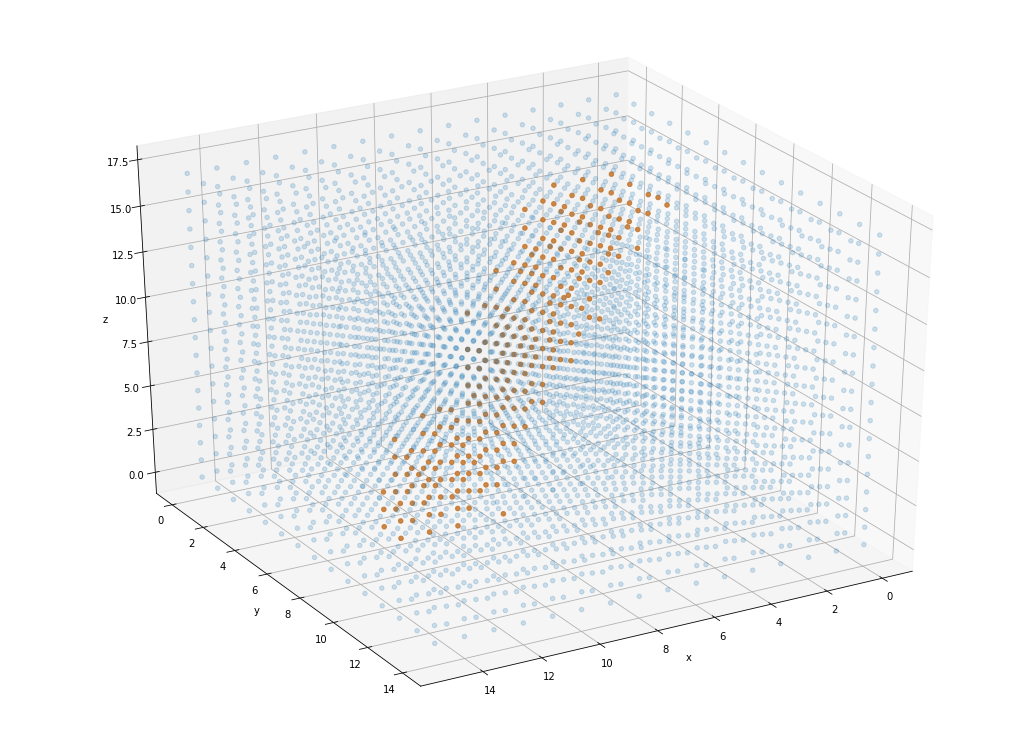

In [110]:

from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure(figsize=(14,10))
ax = Axes3D(fig)

ax.scatter(lol[:,0], lol[:,1], lol[:,2], alpha=0.2)
#for evt in wrong_class_evt_numu2:
#    plot_x_evt(evt)
plot_x_evt(1491)
ax.grid()
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')
ax.view_init(30, 60)
plt.show()
